# 数据处理

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, coint, grangercausalitytests
from statsmodels.tsa.api import VAR

df = pd.read_excel("correlation.xlsx")


# 1. 预处理
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date').sort_index()

# 2. 基础相关性分析
print("皮尔逊相关：", df['yield3'].corr(df['yield2'], method='pearson'))
print("斯皮尔曼相关：", df['yield3'].corr(df['yield2'], method='spearman'))

皮尔逊相关： 0.7005616412389137
斯皮尔曼相关： 0.5528967739133028


# 指标构建

In [14]:
df = pd.read_excel("correlation.xlsx")
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date').sort_index()
df1 = df.drop(df.loc['2024-12-25':'2025-07-25'].index)
df2 = df.drop(df.loc['2024-01-02':'2024-12-25'].index)
df['ret1'] = df['yield1'].pct_change()
df['ret2'] = df['yield2'].pct_change()
df['val1'] = df['yield1'].diff()
df['val2'] = df['yield2'].diff()
df['val3'] = df['yield3'].diff()
df['ret3'] = df['yield3'].pct_change()
df.dropna(inplace=True)

# 滚动相关

In [24]:
# 3. 滚动相关 
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

days = list(range(15, 181, 15))  # 15天到180天的滚动窗口

# 打开一个 PDF 文件
with PdfPages("rolling_correlation_差分.pdf") as pdf:
    for day in days:
        rolling_corr = df['val1'].rolling(day).corr(df['val2'])

        # 新建图像
        fig, ax = plt.subplots(figsize=(24, 12))
        rolling_corr.plot(ax=ax, title=f"Rolling {day}-day Correlation (val1 vs val2)")
        ax.axhline(0, color="red", linestyle="--")
        
        # 保存到 PDF
        pdf.savefig(fig)
        plt.close(fig)  # 关闭当前图，节省内存

# 平稳性检验

In [17]:
# 4. 平稳性检验 (ADF)
df1 = df.drop(df.loc['2024-12-25':'2025-07-25'].index)
for col in ['val1', 'val2']:
    result = adfuller(df[col].dropna())
    print(f"{col} ADF Statistic: {result[0]:.4f}, p-value: {result[1]:.4f}")

val1 ADF Statistic: -10.6837, p-value: 0.0000
val2 ADF Statistic: -6.0555, p-value: 0.0000


# 协整性检验

In [18]:
# 5. 协整检验
df1 = df.drop(df.loc['2024-12-25':'2025-07-25'].index)
coint_t, p_value, _ = coint(df['val1'], df['val2'])
print(f"协整检验统计量: {coint_t:.4f}, p值: {p_value:.4f}")

协整检验统计量: -10.7031, p值: 0.0000


In [26]:
import numpy as np
import pandas as pd
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.vecm import coint_johansen

# ----------------------------
# 0) 数据准备：用“水平值”（非差分！）
# df1: 包含 date, yield1, yield2
# ----------------------------
Y = df[['yield1', 'yield2']]
sel = VAR(Y).select_order(maxlags=12)  # 可按样本大小调整上限
p = sel.aic  # or sel.bic
k_ar_diff = max(0, p-1)  # p=1 -> k_ar_diff=0  ✅
print(f"Selected VAR lag p={p}; use k_ar_diff={k_ar_diff} for Johansen.")

# ----------------------------
# 2) Johansen 检验
#    det_order：确定项设定（常用 0 或 1）
#    - 0: 无确定项（无常数、无趋势）
#    - 1: 协整关系中含常数（最常用）
#    - 2: 协整向量含趋势（较少用）
# ----------------------------
def johansen_test(endog: pd.DataFrame, det_order: int, k_ar_diff: int):
    joh = coint_johansen(endog.values, det_order=det_order, k_ar_diff=k_ar_diff)
    out = {
        "eig": joh.eig,                       # 特征根
        "lr1": joh.lr1,                       # Trace 统计量
        "lr1_crit": joh.cvt,                  # Trace 临界值 [90%,95%,99%]
        "lr2": joh.lr2,                       # Max-Eig 统计量
        "lr2_crit": joh.cvm,                  # Max-Eig 临界值
        "evec": joh.evec                      # 协整向量（列）
    }
    return out

# 跑两种常见设定：det_order=0 与 det_order=1
res0 = johansen_test(Y, det_order=0, k_ar_diff=k_ar_diff)
res1 = johansen_test(Y, det_order=1, k_ar_diff=k_ar_diff)

def print_johansen(res, title):
    print(f"\n=== Johansen ({title}) ===")
    k = len(res["eig"])
    # Trace
    print("\nTrace Statistics (lr1) vs Critical Values:")
    for i in range(k):
        stat = res["lr1"][i]
        cv90, cv95, cv99 = res["lr1_crit"][i]
        print(f" r <= {i}:  stat={stat:8.3f} | cv(90%)={cv90:7.3f}, cv(95%)={cv95:7.3f}, cv(99%)={cv99:7.3f}")
    # Max-eig
    print("\nMax-Eig Statistics (lr2) vs Critical Values:")
    for i in range(k):
        stat = res["lr2"][i]
        cv90, cv95, cv99 = res["lr2_crit"][i]
        print(f" r = {i} vs {i+1}: stat={stat:8.3f} | cv(90%)={cv90:7.3f}, cv(95%)={cv95:7.3f}, cv(99%)={cv99:7.3f}")
    # 协整向量（规范化到第1个变量系数=1）
    beta = res["evec"]
    beta = beta / beta[0, :]  # 以 yield1 系数规范化为 1
    print("\nCointegrating vectors (normalized on yield1):")
    for j in range(beta.shape[1]):
        print(f"  beta{j+1}: yield1*1.0000  + yield2*({beta[1,j]:.4f})")

print_johansen(res0, "det_order=0 (no constant)")
print_johansen(res1, "det_order=1 (const in cointegration)")

Selected VAR lag p=6; use k_ar_diff=5 for Johansen.

=== Johansen (det_order=0 (no constant)) ===

Trace Statistics (lr1) vs Critical Values:
 r <= 0:  stat=  15.521 | cv(90%)= 13.429, cv(95%)= 15.494, cv(99%)= 19.935
 r <= 1:  stat=   6.537 | cv(90%)=  2.705, cv(95%)=  3.841, cv(99%)=  6.635

Max-Eig Statistics (lr2) vs Critical Values:
 r = 0 vs 1: stat=   8.984 | cv(90%)= 12.297, cv(95%)= 14.264, cv(99%)= 18.520
 r = 1 vs 2: stat=   6.537 | cv(90%)=  2.705, cv(95%)=  3.841, cv(99%)=  6.635

Cointegrating vectors (normalized on yield1):
  beta1: yield1*1.0000  + yield2*(-1.1199)
  beta2: yield1*1.0000  + yield2*(2.2866)

=== Johansen (det_order=1 (const in cointegration)) ===

Trace Statistics (lr1) vs Critical Values:
 r <= 0:  stat=  16.960 | cv(90%)= 16.162, cv(95%)= 18.398, cv(99%)= 23.148
 r <= 1:  stat=   6.526 | cv(90%)=  2.705, cv(95%)=  3.841, cv(99%)=  6.635

Max-Eig Statistics (lr2) vs Critical Values:
 r = 0 vs 1: stat=  10.435 | cv(90%)= 15.001, cv(95%)= 17.148, cv(99%)=

d:\conda\envs\lau\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


# 格兰杰因果检验

In [30]:
# 6. 格兰杰因果检验 (最大滞后期设为5)

print("\nGranger Causality Tests (yield1 → yield2 ?)")
grangercausalitytests(df1[['yield2', 'yield1']], maxlag=5)



Granger Causality Tests (yield1 → yield2 ?)

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.0099  , p=0.0840  , df_denom=241, df_num=1
ssr based chi2 test:   chi2=3.0473  , p=0.0809  , df=1
likelihood ratio test: chi2=3.0285  , p=0.0818  , df=1
parameter F test:         F=3.0099  , p=0.0840  , df_denom=241, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.6892  , p=0.1869  , df_denom=238, df_num=2
ssr based chi2 test:   chi2=3.4494  , p=0.1782  , df=2
likelihood ratio test: chi2=3.4251  , p=0.1804  , df=2
parameter F test:         F=1.6892  , p=0.1869  , df_denom=238, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.2197  , p=0.3032  , df_denom=235, df_num=3
ssr based chi2 test:   chi2=3.7680  , p=0.2876  , df=3
likelihood ratio test: chi2=3.7389  , p=0.2911  , df=3
parameter F test:         F=1.2197  , p=0.3032  , df_denom=235, df_num=3

Granger Causality
number of lags (no zero) 4
ssr

{np.int64(1): ({'ssr_ftest': (np.float64(3.009857383048298),
    np.float64(0.08403802394060621),
    np.float64(241.0),
    np.int64(1)),
   'ssr_chi2test': (np.float64(3.0473244874015966),
    np.float64(0.08087026614462534),
    np.int64(1)),
   'lrtest': (np.float64(3.0284523837603956),
    np.float64(0.08181602098359418),
    np.int64(1)),
   'params_ftest': (np.float64(3.0098573830482382),
    np.float64(0.08403802394060952),
    np.float64(241.0),
    1.0)},
   array([[0., 1., 0.]])]),
 np.int64(2): ({'ssr_ftest': (np.float64(1.68920783651392),
    np.float64(0.18687208621000714),
    np.float64(238.0),
    np.int64(2)),
   'ssr_chi2test': (np.float64(3.449390792209097),
    np.float64(0.17822733224513487),
    np.int64(2)),
   'lrtest': (np.float64(3.4251379436680054),
    np.float64(0.18040174980182397),
    np.int64(2)),
   'params_ftest': (np.float64(1.6892078365137564),
    np.float64(0.18687208621003573),
    np.float64(238.0),
    2.0)},
   array([[0., 0., 1., 0., 0.],
  

In [ ]:
# 6. 格兰杰因果检验 (最大滞后期设为5)
df = df.iloc[1:]
print("\nGranger Causality Tests (val2 → val3?)")
grangercausalitytests(df[['yield2', 'val3']], maxlag=5)


Granger Causality Tests (val2 → val3?)

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0230  , p=0.3128  , df_denom=240, df_num=1
ssr based chi2 test:   chi2=1.0358  , p=0.3088  , df=1
likelihood ratio test: chi2=1.0336  , p=0.3093  , df=1
parameter F test:         F=1.0230  , p=0.3128  , df_denom=240, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.6498  , p=0.5231  , df_denom=237, df_num=2
ssr based chi2 test:   chi2=1.3270  , p=0.5151  , df=2
likelihood ratio test: chi2=1.3233  , p=0.5160  , df=2
parameter F test:         F=0.6498  , p=0.5231  , df_denom=237, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.6979  , p=0.5542  , df_denom=234, df_num=3
ssr based chi2 test:   chi2=2.1563  , p=0.5406  , df=3
likelihood ratio test: chi2=2.1467  , p=0.5425  , df=3
parameter F test:         F=0.6979  , p=0.5542  , df_denom=234, df_num=3

Granger Causality
number of lags (no zero) 4
ssr base

{np.int64(1): ({'ssr_ftest': (np.float64(1.0230084849796002),
    np.float64(0.3128250557884742),
    np.float64(240.0),
    np.int64(1)),
   'ssr_chi2test': (np.float64(1.0357960910418451),
    np.float64(0.3088012095202616),
    np.int64(1)),
   'lrtest': (np.float64(1.0335947855244285),
    np.float64(0.309315848866643),
    np.int64(1)),
   'params_ftest': (np.float64(1.0230084849796242),
    np.float64(0.3128250557884742),
    np.float64(240.0),
    1.0)},
   array([[0., 1., 0.]])]),
 np.int64(2): ({'ssr_ftest': (np.float64(0.6497742064454496),
    np.float64(0.5230913159351602),
    np.float64(237.0),
    np.int64(2)),
   'ssr_chi2test': (np.float64(1.3269650460742515),
    np.float64(0.5150545183553339),
    np.int64(2)),
   'lrtest': (np.float64(1.3233401994575615),
    np.float64(0.5159888616264636),
    np.int64(2)),
   'params_ftest': (np.float64(0.6497742064454594),
    np.float64(0.5230913159351532),
    np.float64(237.0),
    2.0)},
   array([[0., 0., 1., 0., 0.],
       

# VECM

In [34]:
import pandas as pd
from statsmodels.tsa.vector_ar.vecm import coint_johansen, VECM

# 假设你的 DataFrame 有 'yield1','yield2'
# df = pd.read_csv(...).dropna()

# 1. 协整检验（Johansen）
jres = coint_johansen(df[['yield1','yield2']], det_order=1, k_ar_diff=2)
print("Trace statistic:", jres.lr1)   # Trace test
print("Critical values (90/95/99%):", jres.cvt)

# 2. 直接估 VECM (包含 ECM 部分)
vecm = VECM(df1[['yield1','yield2']], k_ar_diff=2, coint_rank=1, deterministic="co")  
vecm_res = vecm.fit()
print(vecm_res.summary())

Trace statistic: [15.4167498   5.22523872]
Critical values (90/95/99%): [[16.1619 18.3985 23.1485]
 [ 2.7055  3.8415  6.6349]]
Det. terms outside the coint. relation & lagged endog. parameters for equation yield1
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1373      0.045     -3.032      0.002      -0.226      -0.049
L1.yield1      0.1179      0.064      1.841      0.066      -0.008       0.243
L1.yield2      0.0657      0.157      0.418      0.676      -0.242       0.374
L2.yield1     -0.0242      0.064     -0.376      0.707      -0.150       0.102
L2.yield2     -0.2369      0.157     -1.510      0.131      -0.544       0.071
Det. terms outside the coint. relation & lagged endog. parameters for equation yield2
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------

d:\conda\envs\lau\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


# DCC-GARCH

样本大小: (389, 2)

=== 单变量 GARCH(1,1) 结果: yield1 (Δ) ===
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                           r1   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                659.450
Distribution:      Standardized Student's t   AIC:                          -1308.90
Method:                  Maximum Likelihood   BIC:                          -1289.08
                                              No. Observations:                  389
Date:                      Tue, Aug 19 2025   Df Residuals:                      388
Time:                              17:12:02   Df Model:                            1
                                   Mean Model                                  
                  coef    std err          t      P>|t|        95.0% Conf. Int.
---------------------

d:\conda\envs\lau\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.004674. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
d:\conda\envs\lau\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006156. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
d:\conda\envs\lau\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The opt


=== DCC(1,1) 参数估计 ===
a = 0.0032, b = 0.0001, a+b = 0.0033


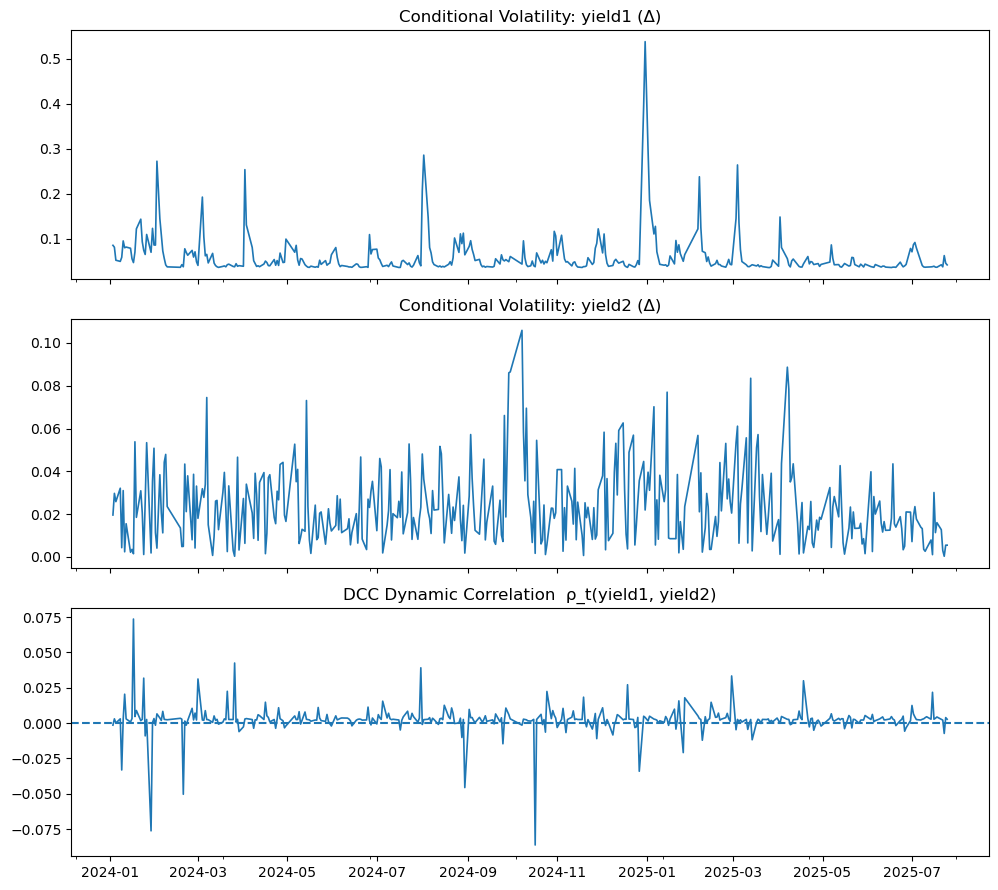


动态相关 ρ_t 概览：
mean    0.002531
std     0.010342
min    -0.086144
max     0.073580
dtype: float64


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Tuple
from scipy.optimize import minimize
from arch import arch_model
from statsmodels.stats.diagnostic import acorr_ljungbox

# 用一阶差分近似“收益率变化”（比水平更适合做GARCH）
r1 = df["val1"]
r2 = df["val2"]
rets = pd.concat([r1, r2], axis=1).dropna()
rets.columns = ["r1", "r2"]

print("样本大小:", rets.shape)

# ============ 1) 单变量 GARCH(1,1) 拟合（Student-t） ============
def fit_garch_series(series: pd.Series):
    # 可按需加入 mean='ARX', lags=k 做 ARMA-mean；这里用常数均值
    am = arch_model(series, mean='constant', vol='GARCH', p=1, q=1, dist='t')
    res = am.fit(disp='off')
    sigma_t = res.conditional_volatility
    std_resid = res.resid / sigma_t
    return res, sigma_t, std_resid

res1, sig1, z1 = fit_garch_series(rets["r1"])
res2, sig2, z2 = fit_garch_series(rets["r2"])

print("\n=== 单变量 GARCH(1,1) 结果: yield1 (Δ) ===")
print(res1.summary())
print("\n=== 单变量 GARCH(1,1) 结果: yield2 (Δ) ===")
print(res2.summary())

# 残差诊断（标准化残差与其平方应近似白噪声）
def ljungbox_report(z, name):
    lb1 = acorr_ljungbox(z.dropna(), lags=[10,20], return_df=True)
    lb2 = acorr_ljungbox((z**2).dropna(), lags=[10,20], return_df=True)
    print(f"\n[Ljung-Box] {name} 标准化残差")
    print(lb1)
    print(f"\n[Ljung-Box] {name} 标准化残差平方")
    print(lb2)

ljungbox_report(z1, "yield1")
ljungbox_report(z2, "yield2")

# ============ 2) DCC(1,1) 参数估计 与 动态相关递推 ============
Z = np.column_stack([z1.loc[rets.index].values, z2.loc[rets.index].values])  # T x 2
Z = Z[~np.isnan(Z).any(axis=1), :]
T_eff = Z.shape[0]

# 样本相关矩阵（标准化残差的无条件相关）
S = np.corrcoef(Z.T)

@dataclass
class DCCResult:
    a: float
    b: float
    Rt: np.ndarray  # (T, 2, 2)
    Qt: np.ndarray  # (T, 2, 2)
    rho12: np.ndarray  # (T,)

def dcc_loglik(params: np.ndarray, Z: np.ndarray, S: np.ndarray) -> float:
    # params 是 unconstrained 的，用变换保证 a>=0, b>=0, a+b<1
    x, y = params  # unconstrained
    a = 1 / (1 + np.exp(-x)) * 0.999   # (0, 0.999) 之间
    b = 1 / (1 + np.exp(-y)) * (0.999 - a)  # 让 a+b < 0.999
    # DCC(1,1) 递推
    T = Z.shape[0]
    Q = S.copy()
    loglik = 0.0
    for t in range(T):
        eps = Z[t][:, None]  # 2x1
        Q = (1 - a - b) * S + a * (eps @ eps.T) + b * Q
        Dinv = np.diag(1 / np.sqrt(np.diag(Q)))
        R = Dinv @ Q @ Dinv
        # 相关矩阵的QML对数似然（相关部分）
        detR = np.linalg.det(R)
        if detR <= 0 or not np.isfinite(detR):
            return 1e12
        invR = np.linalg.inv(R)
        ll_t = np.log(detR) + (eps.T @ invR @ eps).item()
        loglik += ll_t
    return 0.5 * loglik  # 负号在优化器里通过最小化实现

def estimate_dcc(Z: np.ndarray, S: np.ndarray) -> DCCResult:
    # 初始值（logit空间）
    init = np.array([np.log(0.05/0.95), np.log(0.90/0.10)])  # 约 a≈0.05, b≈0.90
    opt = minimize(dcc_loglik, init, args=(Z, S), method='L-BFGS-B')
    x, y = opt.x
    a = 1 / (1 + np.exp(-x)) * 0.999
    b = 1 / (1 + np.exp(-y)) * (0.999 - a)

    # 递推得到全样本 Rt, Qt
    T = Z.shape[0]
    Rt = np.zeros((T, 2, 2))
    Qt = np.zeros((T, 2, 2))
    Q = S.copy()
    rho12 = np.zeros(T)
    for t in range(T):
        eps = Z[t][:, None]
        Q = (1 - a - b) * S + a * (eps @ eps.T) + b * Q
        Dinv = np.diag(1 / np.sqrt(np.diag(Q)))
        R = Dinv @ Q @ Dinv
        Rt[t] = R
        Qt[t] = Q
        rho12[t] = R[0, 1]
    return DCCResult(a=a, b=b, Rt=Rt, Qt=Qt, rho12=rho12)

dcc_res = estimate_dcc(Z, S)
print(f"\n=== DCC(1,1) 参数估计 ===\na = {dcc_res.a:.4f}, b = {dcc_res.b:.4f}, a+b = {dcc_res.a+dcc_res.b:.4f}")

# ============ 3) 可视化：两条条件波动 & 时变相关 ============
fig, axes = plt.subplots(3, 1, figsize=(10, 9), sharex=True)
sig1.loc[rets.index].plot(ax=axes[0], title="Conditional Volatility: yield1 (Δ)", lw=1.2)
sig2.loc[rets.index].plot(ax=axes[1], title="Conditional Volatility: yield2 (Δ)", lw=1.2)
axes[2].plot(rets.index[-len(dcc_res.rho12):], dcc_res.rho12, lw=1.2)
axes[2].axhline(0, ls='--')
axes[2].set_title("DCC Dynamic Correlation  ρ_t(yield1, yield2)")
plt.tight_layout()
plt.show()

# ============ 4) 小结输出 ============
print("\n动态相关 ρ_t 概览：")
print(pd.Series(dcc_res.rho12, index=rets.index[-len(dcc_res.rho12):]).describe()[["mean","std","min","max"]])